In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import warp, make_grid
from evaluator import save_plots
from submodels import Generative_Encoder, Generative_Decoder, Evolution_Network,Noise_Projector
from torch.autograd import Variable
from model_make import *
from dataset import *
args = {
    'batch_size': 1,
    'worker': 1,
    'device':'cuda:0',
    'cpu_worker': 1,
    'dataset': 'dBZ',
    'data_path':'Data',
    'input_data_type': 'float32',
    'image_width': 256,
    'image_height': 256,
    'case_type':'normal',
    'total_length':10,
    'input_length':10,
    'pred_length':10,
    'ngf':32,
    
}  # 配置信息
args['ic_feature'] = args['ngf'] * 10
args['evo_ic'] = 20
args['gen_oc'] = 10

In [2]:
import torch
configs = args
model = torch.load('epoch_98generator.pth')
model = model.to(configs['device'])
data_loader = make_dataloader(args)
class MaxPoolLoss(nn.Module):
    def __init__(self):
        super(MaxPoolLoss,self).__init__()
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
    
    def forward(self, true_image, fake_image):
        true_image = true_image[...,0]
        fake_image = fake_image[...,0]
        output1 = self.pool1(true_image)
        output2 = self.pool2(fake_image)
        loss = torch.mean(torch.square(output1 - output2))
        return loss

In [3]:
for batch_id, (x_data,y_data) in enumerate(data_loader):
    x_data = x_data.numpy()
    y_data = y_data.numpy()
    x_data = torch.FloatTensor(x_data).to(configs['device'])
    y_data = torch.FloatTensor(y_data).to(configs['device'])
    break

In [4]:
# defines two global scope variables to store our gradients and activations 
gradients = None 
activations = None 

def backward_hook(module, grad_input, grad_output): 
    global gradients # refers to the variable in the global scope 
    print('Backward hook running...') 
    gradients = grad_output 
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8]) 
    print(f'Gradients size: {gradients[0].size()}')  
    # We need the 0 index because the tensor containing the gradients comes 
    # inside a one element tuple. 

def forward_hook(module, args, output): 
    global activations # refers to the variable in the global scope 
    print('Forward hook running...') 
    activations = output 
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8]) 
    print(f'Activations size: {activations.size()}')
backward_hook = model.conv_merge.register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.conv_merge.register_forward_hook(forward_hook, prepend=False)

In [5]:
model

NowcastNet(
  (evo_net): Evolution_Network(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (single_conv): Sequential(
        (0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [6]:
maxpool_loss = MaxPoolLoss().to(configs['device'])
fake_img = model(x_data)
loss_p = maxpool_loss(y_data[...,:1],fake_img)
loss_p.backward()

Forward hook running...
Activations size: torch.Size([1, 1, 256, 256, 10])
Backward hook running...
Gradients size: torch.Size([1, 1, 256, 256, 10])


In [7]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

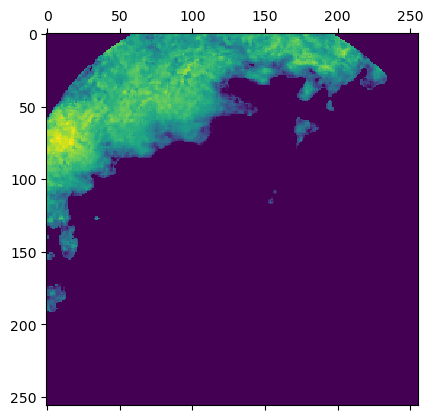

In [8]:
import torch.nn.functional as F 
import matplotlib.pyplot as plt 

# weight the channels by corresponding gradients 
for i in range(activations.size()[1]): 
    activations[:, i, :, :] *= pooled_gradients[i] 

# average the channels of the activations 
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap 
heatmap = F.relu(heatmap) 

# normalize the heatmap 
heatmap /= torch.max(heatmap)

# draw the heatmap 
heat = heatmap[...,0]
plt.matshow(heat.detach().cpu())

<Axes: >

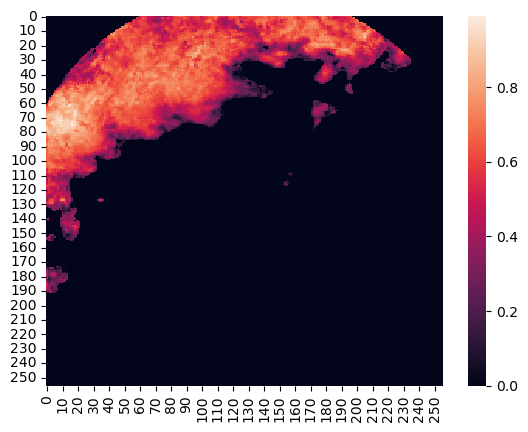

In [9]:
flight = heat.cpu().detach().numpy()
import seaborn as sns
sns.heatmap(flight,annot=False)

In [10]:
import matplotlib.pyplot as plt
def plot_array(file_array):
    norm_dict = {'dBZ': [0, 65],'ZDR': [-1, 5],'KDP': [-1, 6]}
    mmin, mmax = norm_dict['dBZ']
    data_frame = file_array
    data_frame = (data_frame-mmin) / (mmax - mmin)
    data_frame = data_frame.astype('float32')
    ax = plt.axes()
    ax.set_axis_off()
    data = data_frame
    cmap="viridis"
    img = ax.imshow(data)
    plt.show()  


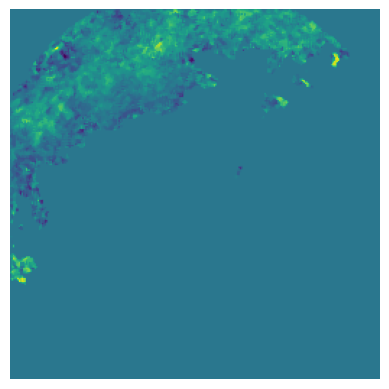

In [14]:
truth = x_data[0,1,:,:,2]
plot_array(truth.cpu().numpy())

In [12]:
truth = x_data[0,1,:,:,1].cpu().detach().numpy()
heatmap1 =heatmap.cpu().detach().numpy()
np.mean(np.square(truth - heatmap1))

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,10) 

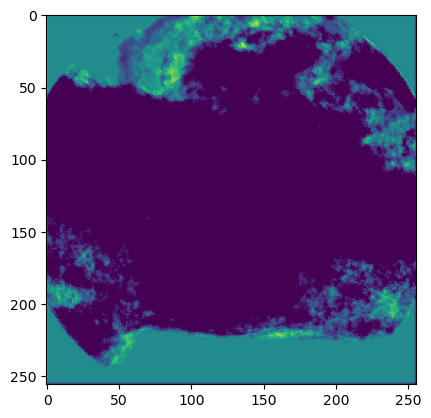

In [ ]:
plt.imshow(heatmap1,cmap="viridis")

In [ ]:
def plot_array(file_array,file_path):
    # norm_dict = {'dBZ': [0, 65],'ZDR': [-1, 5],'KDP': [-1, 6]}
    # mmin, mmax = norm_dict['dBZ']
    data_frame = file_array
    # data_frame = (data_frame-mmin) / (mmax - mmin)
    data_frame = data_frame.astype('float32')
    ax = plt.axes()
    ax.set_axis_off()
    data = data_frame
    cmap="viridis"
    img = ax.imshow(data)
    plt.savefig(file_path)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'q1res/x9.png'

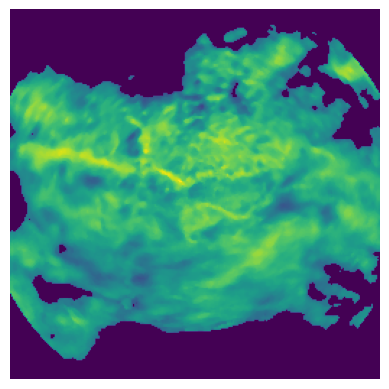

In [ ]:
i = 9
reason = x_data[0,i,:,:,0]
plot_array(reason.cpu().numpy(),"q1res/x{}.png".format(i))

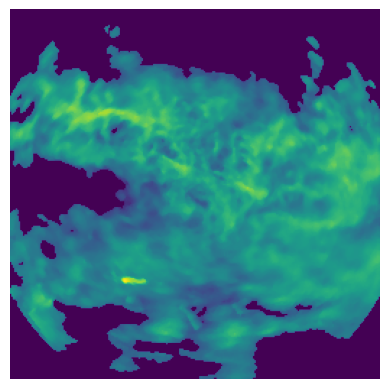

In [ ]:
truth = y_data[0,i,:,:,0]
plot_array(truth.cpu().numpy(),"q1res/y{}.png".format(i))

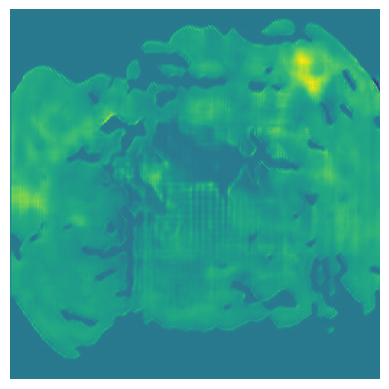

In [ ]:
pre = fake_img[0,i,:,:,0]
plot_array(pre.cpu().detach().numpy(),"q1res/p{}.png".format(i))